# Задачи детекции и сегментации на изображениях

##Что такое сегментация и детекция

**Сегментация** $(segmentation)$ — задача присвоения каждому пикселю изображения метку класса или экземляра, то есть попиксельная классификация.

**Детекция** $(object\ detection)$ — задача поиска объектов на изображении и выделении их ограничивающими прямоугольниками $(bounding\ boxes)$ с указанием класса.

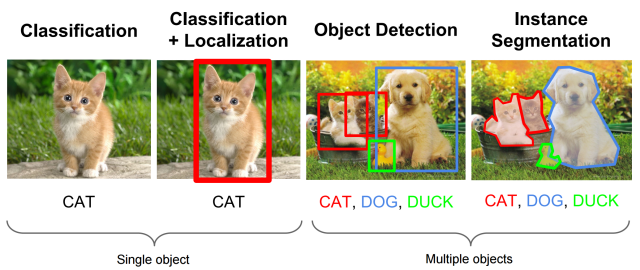

Основные **виды** сегментации:

* `Semantic segmentation` — присвоение каждому пикселю класса без различения объектов внутри одного класса.
* `Instance segmentation` — каждый отдельный объект (экземпляр) одного класса получает свою маску, однако фон не обрабатывается.
* `Panoptic segmentation` — объединение двух предыдущих подходов.

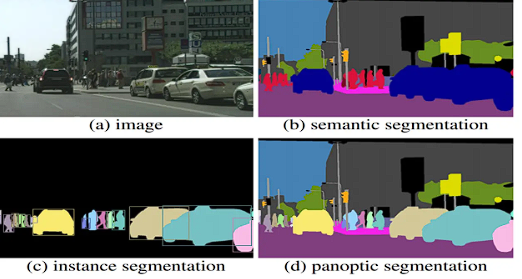

##Детекция

###Базовые понятия

**Ограничивающий прямоугольник** описывается четырьмя числами. В практике используют два основных представления. Первое представление задаёт координаты левого верхнего и правого нижнего углов прямоугольника: $(x_{\text{min}}, y_{\text{min}}, x_{\text{max}}, y_{\text{max}})$.

Второе представление задаёт центр и размеры: $(x_c, y_c, w, h)$. Часто координаты нормируют относительно ширины и высоты изображения, чтобы значения были в диапазоне $[0,1]$.

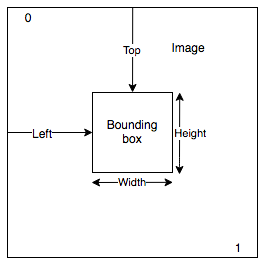

Качество совпадения двух прямоугольников измеряется **метрикой** `Intersection over Union` обозначаемой `IoU`. Для двух областей $A$ и $B$ определяется:
$$
\mathrm{IoU}(A,B)=\frac{|A\cap B|}{|A\cup B|}.
$$

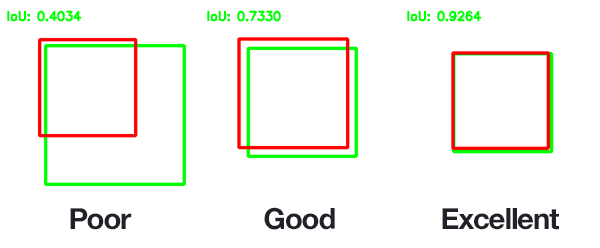

`IoU` равен единице при полном совпадении и равен нулю при отсутствии пересечения. `IoU` используется и при отборе положительных и отрицательных примеров во время обучения, и при оценке качества прогнозов на тестовой выборке.

**Формат разметки** для детекции включает список прямоугольников и соответствующие классы для каждого изображения. Для инстансной сегментации дополнительно хранятся бинарные маски для каждого экземпляра.

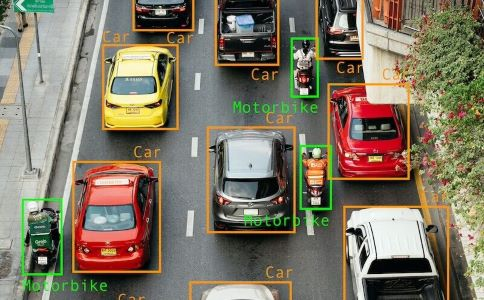

### Детекция скользящим окном

Ранние **методы детекции** опирались на идею скользящего окна. Изображение просматривалось сеткой окон разных размеров и для каждого окна вычислялись признаки с последующей классификацией.

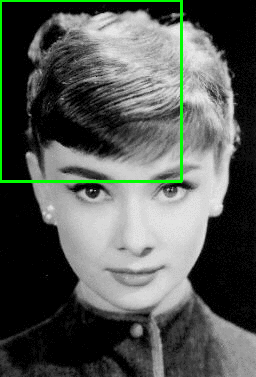

Например, можно передавать **регион** в **`CNN`**, обученную на задачу классификации. Чем ближе предсказание модели к $1$, тем выше вероятность, что в заданном прямоугольнике нужный объект. В итоге выбираем наиболее подходящий прямоугольник из доступных.

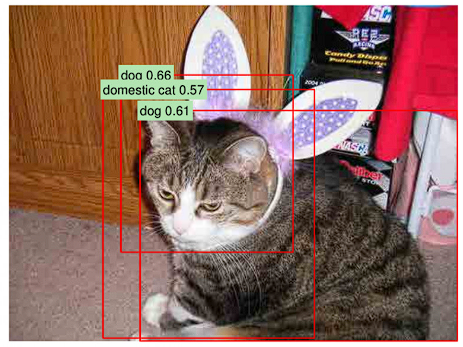

Этот подход простой и понятный, но **неэффективный**: для изображения средней величины нужно проверить десятки тысяч окон, а вычисление признаков повторяется для многих перекрывающихся регионов.

Идея скользящего окна сохраняет смысл в **современных** нейросетевых подходах, но оптимизация достигается за счёт вычисления признаков для всего изображения один раз и повторного использования этих признаков для множества кандидатов.

### Одношаговые детекторы. YOLO

**Одношаговые детекторы** предсказывают координаты прямоугольников и вероятности классов напрямую на карте признаков без отдельной стадии генерации предложений. Это даёт низкую задержку и хорошую скорость, что важно для приложений реального времени.

Концепция первого семейства моделей **`YOLO`** заключается в разбиении изображения на сетку размером $S\times S$. Каждая ячейка этой сетки отвечает за обнаружение объектов, центры которых попадают в эту ячейку.

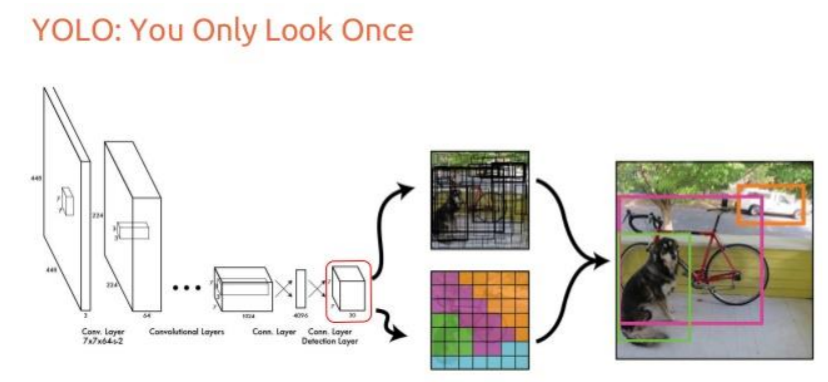

Вероятность присутствия объекта в боксе обозначается $p_{\text{obj}}$. Условная вероятность класса при данном объекте задаётся векторами $p_1,\dots,p_K$. Итоговая оценка принадлежности бокса к классу $k$ получается как произведение уверенности наличия объекта на условную вероятность класса.

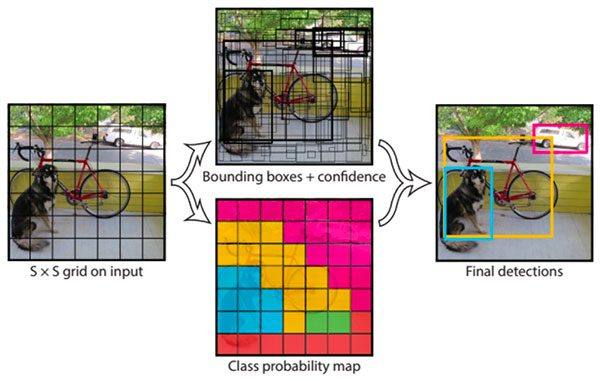

В базовой версии **каждая ячейка** предсказывает несколько кандидатов ограничивающих прямоугольников и вероятности классов. Для каждого кандидата сеть выдает параметры, которые преобразуются к реальным координатам бокса.

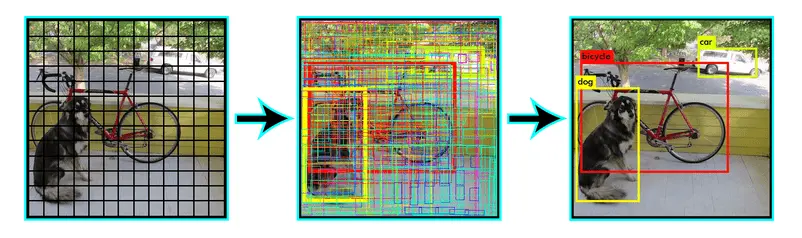

**Функция потерь** в YOLO включает три члена:

1. Первый член отвечает за **координаты** и награждает точную регрессию бокса.

2. Второй член отвечает за уверенность **наличия объекта** и штрафует ложные тревоги или пропуски.

3. Третий член это **классификационный лосс**, который штрафует неправильные предсказания класса.

Практическая реализация балансирует вклад этих членов с помощью **весовых** коэффициентов $\lambda$, поскольку численно вклад регрессии и классификации разных величин.

### Подход SSD

Идея **`SSD`** $(Single\ Shot\ Detector)$ заключается в предсказании боксов на различных уровнях карты признаков.

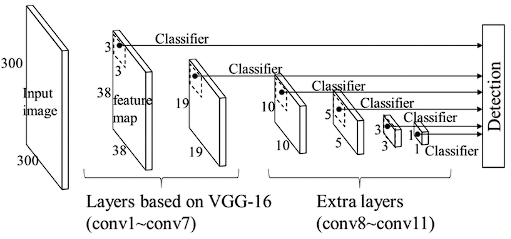

Карты признаков разного разрешения служат для обнаружения объектов разных размеров.

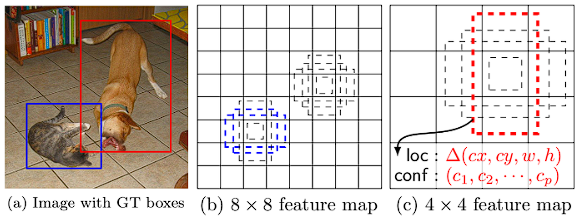

### Двухшаговые методы. R-CNN

**Двухшаговый детектор** строится из двух логических модулей. Первый модуль генерирует небольшое число качественных регионов-кандидатов, которые с большой вероятностью содержат объекты. Второй модуль берёт каждого кандидата, извлекает корректные признаки и выполняет уточнение класса и координат, при необходимости строит маску.

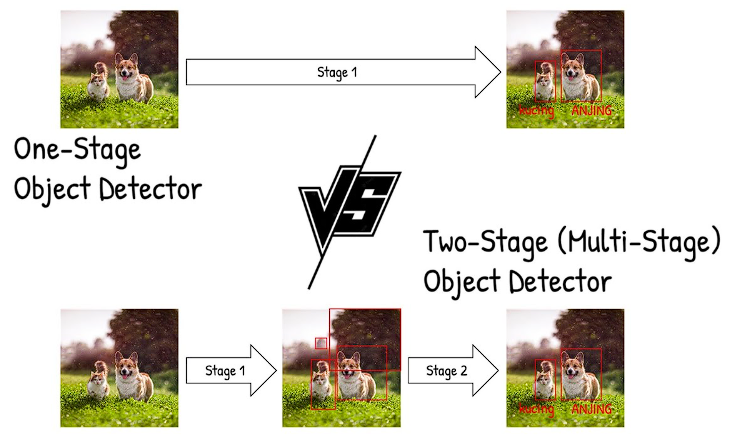

**`R-CNN`** $(Region-based\ Convolutional\ Neural\ Network)$ стал первым нейросетевым детектором, который показал, что свёрточные сети можно эффективно использовать для задачи обнаружения объектов. Его ключевая идея заключается в разделении задачи детекции на **два этапа**: генерацию регионов-кандидатов и обработку их `CNN`.

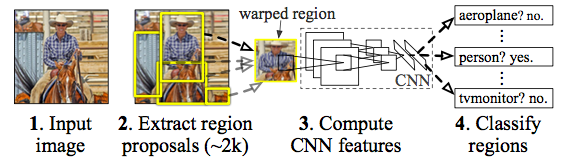

###Selective Search

В ранних вариантах `R-CNN` генерация регионов, о которых известно, что в них имеется некий объект, делалась классическими алгоритмами типа **`Selective Search`**, которые на базе низкоуровневых сегментаций выдавали сотни или тысячи предложений.

Для каждого предложения кадр предварительно приводили к фиксированному размеру и пропускали через **`CNN`** для классификации и регрессии. Такой подход давал хорошее качество, но был медленным из за многократных прогонов `CNN` для пересекающихся регионов.

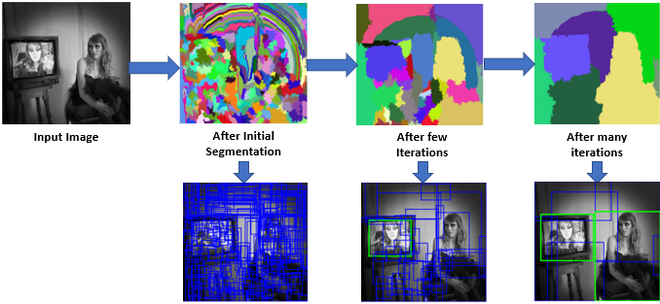

## Семантическая сегментация

###Подход encoder–decoder

Переходя к **сегментации**, семантическая задача формулируется как попиксельная классификация. Основной архитектурный шаблон — это `encoder–decoder`. `Encoder` постепенно уменьшает пространственные размеры и извлекает семантические признаки. `Decoder` восстанавливает пространственный размер до исходного и предсказывает карту классов на уровне пикселей.

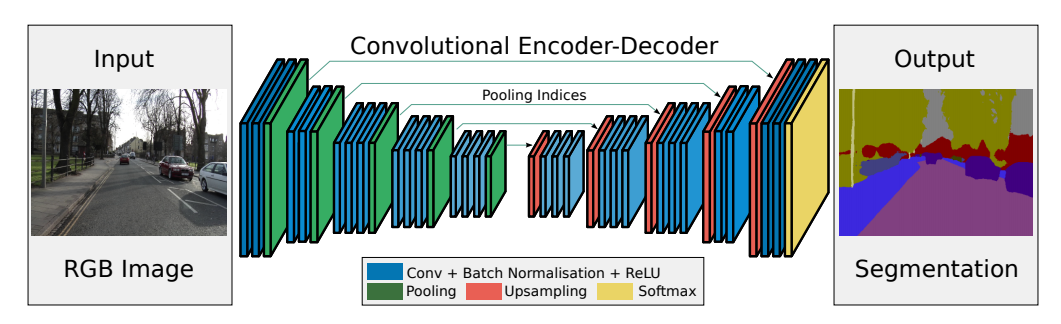

Ключевая трудность — это потеря детальных локальных признаков при слишком сильном **сжатии** в `encoder`. Решением служат **пропускные связи**, которые соединяют ранние слои `encoder` с соответствующими шагами `decoder` и таким образом возвращают локальную информацию при восстановлении.

###U-Net

**`U-Net`** — это реализация идеи `encoder-decoder`, где симметричный контрактирующий блок сменяется экспандирующим блоком и между парами блоков установлены **прямые соединения**. `U-Net` великолепно подходит для задач, где важны тонкие контуры и детальная маска, например в медицине.

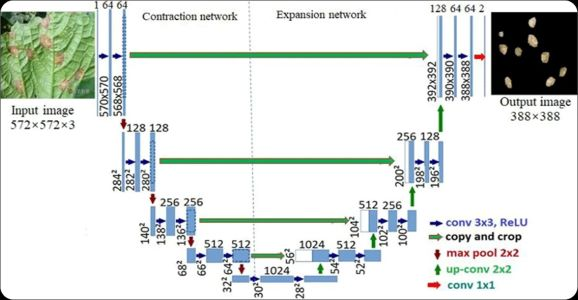

###DeepLab

Альтернативный подход **`DeepLab`** использует дилатированные свёртки, которые увеличивают **рецептивное поле** без уменьшения пространственного разрешения. Дилатация полезна, когда требуется учесть широкий контекст при сохранении разрешения.

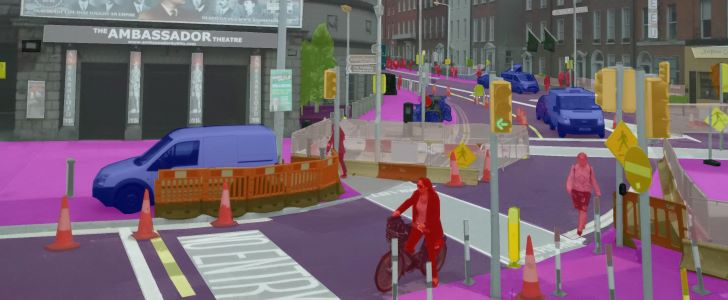

###Mask R-CNN

Инстансная сегментация чаще всего связывается с **`Mask R-CNN`**, где для каждого обнаруженного экземпляра строится маска. Это объединяет преимущества детекции и пиксельной сегментации.

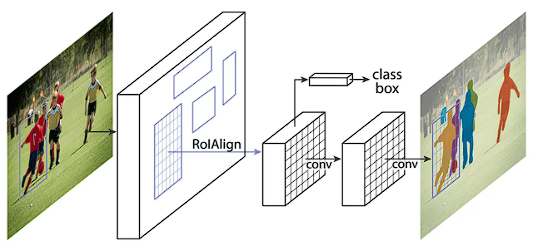

## Пример. Детекция кошек на фото с использованием Ultralytics YOLOv8

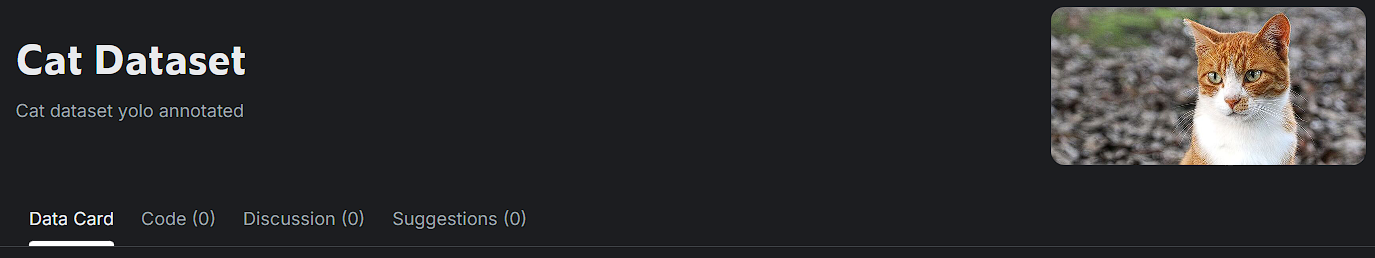

Обучим модель `YOLOv8` для детекции кошек на датасете с 1000 изображений.

###Сбор и подготовка данных

Установим библиотеку для скачивания датасета

In [2]:
!pip install -q opendatasets

Сохраним токен Kaggle в необходимой для opendatasets директории.

In [3]:
from google.colab import files
import os

uploaded = files.upload()

Saving kaggle.json to kaggle.json


Скачаем датасет.

In [4]:
import opendatasets as od

url = 'https://www.kaggle.com/datasets/samuelayman/cat-dataset'
od.download(url)

Dataset URL: https://www.kaggle.com/datasets/samuelayman/cat-dataset


100%|██████████| 127M/127M [00:00<00:00, 1.48GB/s]

Датасет содержит две папки. В `Images` изображения `JPG` разного размера, в `labels` — файлы с `bbox` в формате `TXT`.

In [7]:
os.listdir('./cat-dataset/cat')

['labels', 'Images']

In [8]:
from pathlib import Path
import random, shutil

random.seed(42)
root = Path("cat-dataset/cat")
imgs = sorted((root / "Images").glob("*.jpg"))
labels_dir = root / "labels"

Сделаем `hold-out` в соотношении `80/20`. Датасет сформирован из другого, где было несколько классов. Класс кошки был под индексом 25. Переобозначим в индекс 0. На изображении может быть несколько кошек.

In [32]:
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(imgs, test_size=0.2, random_state=42, shuffle=True)

out = Path("yolo_cat")
for sub in ["images/train", "images/val", "labels/train", "labels/val"]:
    (out / sub).mkdir(parents=True, exist_ok=True)

def copy_split(file_list, part):
    for img in file_list:
        lbl = labels_dir / (img.stem + ".txt")
        shutil.copy(img, out / f"images/{part}" / img.name)

        lines = lbl.read_text().strip().splitlines()
        modified_lines = ["0 " + line.split(' ', 1)[1] for line in lines]
        (out / f"labels/{part}" / lbl.name).write_text("\n".join(modified_lines) + "\n")

copy_split(train_files, "train")
copy_split(val_files, "val")
print("Train:", len(list((out/"images/train").glob("*.jpg"))))
print("Val:  ", len(list((out/"images/val").glob("*.jpg"))))

Train: 800
Val:   200


Создадим описание датасета в формате `YAML`. Это необходимо для работы конкретной реализации `YOLO`, которую мы будем обучать.

In [33]:
import yaml

data_yaml = {
    'path': str(out.resolve()),
    'train': 'images/train',
    'val': 'images/val',
    'names': ['cat']
}

with open('cat_data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

###Моделирование

Установим библиотеку `Ultralytics` для работы с `YOLO`.

In [34]:
!pip install -q ultralytics

Инициализируем `YOLO` готовым предобученным весомю

In [39]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

Обучаем модель с учётом ранее созданного конфига `YAML`.

In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.train(
    data='cat_data.yaml',
    epochs=20,
    imgsz=640,
    device=device,
)


Ultralytics 8.3.249 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cat_data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=T

###Анализ результатов

Выведем несколько примеров предсказания.

In [ ]:
!pip install -q opencv-python

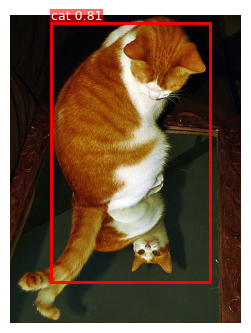

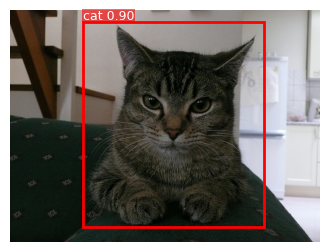

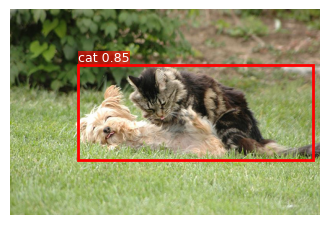

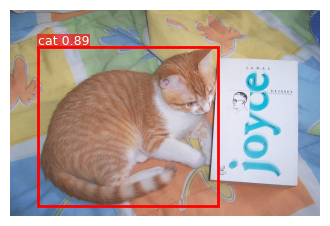

In [45]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

val_dir = Path("yolo_cat/images/val")
imgs = sorted(val_dir.glob("*.*"))[:4]

for img_path in imgs:
    img_bgr = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    res = model.predict(source=str(img_path), conf=0.25, device=device, verbose=False)[0]

    boxes = res.boxes.xyxy.cpu().numpy()
    classes = res.boxes.cls.cpu().numpy()
    scores = res.boxes.conf.cpu().numpy()
    names = model.names

    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.imshow(img_rgb)
    ax.axis('off')

    # На изображении может быть несколько объектов, поэтому
    # обрабатываем случай нескольких bbox
    for (x1, y1, x2, y2), c, s in zip(boxes, classes, scores):
        w, h = x2 - x1, y2 - y1
        rect = plt.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 6, f"{names[int(c)]} {s:.2f}", color='white',
                fontsize=9, bbox=dict(facecolor='red', alpha=0.6, pad=0.3, edgecolor='none'))

    plt.show()


##Выводы

В ходе занятия мы:

1. Познакомились с задачами детекции и сегментации.
2. Определили базовые понятия детекции.
3. Рассмотрели одно- и двушаговые архитектуры детекторов и важнейшие подходы к их оптимизации.
4. Привели основные архитектуры нейросетей для сегментации.
5. Решили задачу детекции на примере датасета с 1000 фото кошек.

##Данные об авторе

Зюков Алексей Алексеевич,

лаборант отдела-онлайн образования НИЯУ МИФИ,

бакалавр кафедры суперкомпьютерных технологий в инженерно-физическом моделировании НИЯУ МИФИ.

##Список использованной и рекомендованной литературы

1. Детекция объектов. R-CNN, Fast R-CNN, Faster R-CNN. Часть 1. — Текст : электронный. / nepexom // Хабр : [сайт]. — 2024. — 29 января. — URL: habr.com (дата обращения: 01.11.2025).
2. Егоров, А. Д. Репозитории с лекциями по анализу данных в НИЯУ МИФИ. – Текст : электронный / А. Д. Егоров // GitHub : [сайт]. – URL: https://github.com/ShadarRim (дата обращения: 01.11.2025).
3. Малов, Д. А. Глубокое обучение и анализ данных : практическое руководство. / Д. А. Малов. – Текст : непосредственный. – Санкт-Петербург : БХВ-Петербург, 2023. – 272 с. : ил. – ISBN 978-5-9775-1172-8.

